# Lab 5

### Keira Hansen and Alex Foster

Our data is from an experiment called MJ60, named after the physicist Majorana, which is a side project from an experiment aptly named Majorana Demonstrator, looking for Majorana particles in neutrinoless double beta decay. 

A little background on our detector. Since I can not figure out how to attach images to my notebook I will just describe the detector and point you to an image I have uploaded of it to github. We use an enriched germanium solid state detector. It can be described as a short cylinder with a beveled edge on one end. For the MJ60 experiment the beveled edge is faced down in the cryostat but in the project I'm currently working on, CAGE, which uses the same type of detector, the beveled edge is orientated upwards. A germanium detector acts like a giant diode with a p point contact on the beveled face of the detector and a n contact on all other surfaces, up to the edge of the bevel. The space between the bevel and the point contact is called the "passivated surface" which  seperates the p and n contacts and allows for an electric field field inside the detector. The electric field moves electron-positron pairs, created when interactions occur inside the detector, to the point contact and the outer contact. The signal we measure is the electrons that traveled to the p point contact from somewhere inside the detector.

We enrich our Germanium detectors with Germanium-76 since it's a known isotope that preferentially decays by bouble beta decay into Selenium-76 instead of by single beta decay into Arsenic-76. Selenium-76 has lower binding energy than Arsenic-76 so it will take less energy for Germanium-76 to decay into Selenium-76. For more information on why Germanium dectector are prefereable for this kind of measurement I would recomend chapters 11 and 12 from 'Radiation Detection and Measurement' by Knoll.

The other important part of our setup is the LMFE that I refered to earlier. LMFE stands for low mass front end which has very low mass to eliminate a lot of noise from radio-impure elements in almost all electronics. The LMFE is attached to the detector using a pogo pin touching the p point contact. Again I will upload an image of the LMFE to github and try my hardest to describe it clearly in my report. The LMFE circuit comprises of a FET with the source grounded and a feedback of a resistor in parallel with a capacitor. You will also see a pulser input which is used to probe the responce of the LMFE using a function generator. This line will is not important for our usage since it is only used to test the LMFE and not when we are recording runs.

Our data is made up of a set of waveforms, these waveforms are the same as what you would see if you hooked up the drain of the FET to an oscilloscope. The electrons that drift to the point contact of the detector create a charge build up on the capacitor and the resistor slowly bleeds the charge away to reset the system for when another signal comes in.

The shape of the waveforms tells us a lot about the event. Some distinctions we make between events are alpha events versus gamma events and single site events versus multisite events. Gamma events are when a gamma particle that enters the detector interacts with the Germanium nuclei, an alpha event on the other hand is when an alpha particle enters the detector and interact with the Germanium nuclei. There are also multi site events which is when a particle enters the detector, interacts at one spot, loosing some of it's energy, and then interacting somewhere else. 

With gamma events the waveforms have a much sharper transition into the tail of the waveform whereas alpha events have a more gradual transition that looks more curved and will rise before a gamma event waveform would rise. Alpha event waveforms also have a feature where the tail decays slower than that of a gamma event waveform. Multi site events are when a gamma comes in interacts in one spot in the detector, produces another gamma that then interacts in another spot in the detector. The resulting waveforms will look like two smaller single site waveforms stacked on top of each other. The waveform will rise due to the first event then the charge will start to bleed off but before it the other event will cause another rise and then that charge will bleed off.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy.optimize import curve_fit
from ROOT import TH1D, TF1, TCanvas

t1_df = pd.read_hdf('t1_run884.h5', key='/ORSIS3302DecoderForEnergy')

energy = t1_df.energy
waveform1 = t1_df.iloc[50, 9:]
waveform2 = t1_df.iloc[300, 9:]
waveform3 = t1_df.iloc[641, 9:]

Welcome to JupyROOT 6.14/06


> First I will give a quick primer on how our data is organized. The data is formated in a pandas dataframe, with one waveform (ie. signal from the detector) in each row and the columns corresponding to something we have measured about the waveform. The columns of interest are the energy column that represents the amplitude of the waveform. There is also a timestamp column that contains when the digitizer recorded each event which could be useful to go back a trace when an event occured and what else occured at that time to make correlations between data. There are also columns that are only labeled by numbers and these correspond to a point in the waveform, seperated by 10ns which is the interval the digitizer was recording points for. 

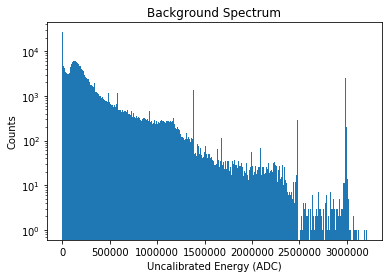

In [2]:
plt.hist(energy, 500)
plt.yscale('log')
plt.title('Background Spectrum')
plt.xlabel('Uncalibrated Energy (ADC)')
plt.ylabel('Counts')
plt.show()

> The raw energy data points are ploted in the histogram above. The scale is logged to better see the peaks that form from certain radioactive elements. I am going to start from right (large energies) to left (small energies) and point out the notable features in the spectrum. The first very tall and sharpe peak at around 3000000 ADC is the muon peak. Our digitizer threshold cuts off the rest of the muon peak so we are just left with the very front of the peak. The next sharpe peak at about 2500000 ADC is the Thallium (208Tl) peak. Thallium shows up in our spectrum due to its abundance in the atmosphere, the data was taken above ground minimal shielding, since it's a background run, so it picks up on the radioactive Thallium. The next sharpe peak just below 1500000 ADC is potassium (40K). Potassium is abundunt in many materials and most materials that were not produced to be very radio-pure will have some potassium in them which is why our detector picks it up. At the very low energy end of the spectrum you can see a dip and then a spike, that is our background threshhold which we offset since the noise at that end of the spectrum isn't easily fitted. For a background run where we are just characterizing the detector it is not necessary to have great precision at this end of the spectrum, the other peaks will do just fine.

In [34]:
energy_list = energy.tolist()
hist = TH1D('h1d', 'Uncalibrated Energy Spectrum', 600, 0, 3000000)
for i in range(len(energy_list)):
    hist.Fill(energy_list[i])
hist.SetTitle('Uncalibrated Energy Spectrum')
hist.GetYaxis().SetTitle('Count')
hist.GetXaxis().SetTitle('Uncalibrated Energy')

K_fit = TF1('K', 'gaus(0)+expo(3)', 1340000, 1410000)
K_fit.SetParameters(500, 1387500, 3500, 10, -1./400000.)

Tl_fit = TF1('Tl', 'gaus(0)+expo(3)', 2400000, 2500000)
Tl_fit.SetParameters(30, 2480000, 10000, 10, -1./400000.)

run_canvas = TCanvas("run_canvas", "run canvas")
run_canvas.SetLogy()
hist.Fit(K_fit, 'LR')
hist.Fit(Tl_fit, 'LR+')
hist.Draw()

run_canvas.Print(('~/phys-measurement/uncalibrated_fit.pdf' + '['))
run_canvas.Print(('~/phys-measurement/uncalibrated_fit.pdf'))
run_canvas.Print(('~/phys-measurement/uncalibrated_fit.pdf' + ']'))

 FCN=35.3171 FROM MIGRAD    STATUS=CONVERGED     257 CALLS         258 TOTAL
                     EDM=5.44763e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.3 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.64399e+03   5.44184e+01   5.08050e-02  -1.65629e-07
   2  p1           1.38688e+06   5.15774e+01  -3.99430e-02  -2.18347e-07
   3  p2           2.46480e+03   3.16596e+01  -4.38318e-02  -1.32430e-07
   4  p3           1.77002e+01   2.32143e+00   1.42519e-04  -2.28596e-03
   5  p4          -9.77407e-06   1.69693e-06  -6.75818e-11  -3.16365e+03
                               ERR DEF= 0.5
 FCN=19.0935 FROM HESSE     STATUS=NOT POSDEF     31 CALLS         336 TOTAL
                     EDM=1.17935e-09    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR        

Warning in <TROOT::Append>: Replacing existing TH1: h1d (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: run_canvas
Info in <TCanvas::Print>: pdf file /Users/keirahansen/phys-measurement/uncalibrated_fit.pdf has been created
Info in <TCanvas::Print>: Current canvas added to pdf file /Users/keirahansen/phys-measurement/uncalibrated_fit.pdf
Info in <TCanvas::Print>: pdf file /Users/keirahansen/phys-measurement/uncalibrated_fit.pdf has been closed


> I have used a library called ROOT which is a python wrapper for a set of C code that was developed by CERN. It is an absolute nightmare to download, since physicists are not the best software engineers, so I know that most people will not be able to run the code but I really only need it to get a good fit for the position of the 40K and 208Tl peaks. The reason I used ROOT's fit function over scipy's curve fit function is mostly because I am more familliar with it but also because the fit is very robust and since I only have to fit one spectrum I am eyeing the initial parameters by eye.

> The function I am fitting to is $\displaystyle f(x) = a\,e^{\left( \frac{x\,-\,\mu}{\sigma} \right)^2} + e^{mx\,+\,b}$, which is a gaussian on top of an exponential. For us $a$ _(p0)_ is the height or number of counts in a peak, $\mu$ _(p1)_ is the position of the center of the peak, $\sigma$ _(p2)_ is the width of the peak, $b$ _(p3)_ is the intercept of the background exponential, and $m$ _(p4)_ is the slope of the background exponential.

1451.4510599999999
2599.71006


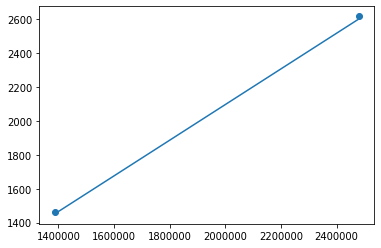

In [49]:
def func(x):
    return 0.00105 * x - 4.77294
adcs = [1.38688e+06, 2.48046e+06]
energies = [1460, 2615]

x = np.arange(1.38688e+06, 2.48046e+06)
y = 0.00105 * x - 4.77294

plt.scatter(adcs[0], energies[0], label='40K')
plt.scatter(adcs[1], energies[1], label='208Tl')
plt.plot(x, y, label='energy(keV) = 0.00105 $\cdot$ energy(ADC) + 4.77294')
plt.show()

> Our signals get amplified by a preamplifier and then goes through a digitizer so the amplitude of our waveforms is now only proportional to the original energy of the electron from the detector. The units of the first 'uncalibrated' spectrum in ADC which is just an arbitrary units assigned by the digitizer but we want our spectrum to be in keV, the unit of the energy the electrons actually had before the signal was amplified. Using hindsight I know that this proportionality is not constant. To get a better calibration I am going to fit a function to the proportionality and since I am only using two peaks this function will be linear, although a quadratic would be more accurate if I used more known peaks. This line above gives me a function that provided with an energy in ADC will give you the corresponding energy in keV. 

> To find the calibration function I am going to use the two most notable features on the spectrum, the Potassium and Thallium peaks. We know from the fit I did above that the Potassium peak is centered at 1.38688e+06 ADC and the Thallium peaks is centered at 2.48046e+06 ADC. We also know that the energy corresponding to that peak is 1460 keV and for Thallium it's 2615 keV (values from NUDAT2 https://www.nndc.bnl.gov/nudat2/getdataset.jsp?nucleus=40K&unc=nds and https://www.nndc.bnl.gov/nudat2/getdataset.jsp?nucleus=208TL&unc=nds). These two points create a line representing the calibration function.

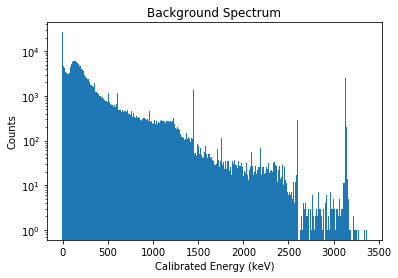

In [50]:
calibrated_energy = []
for energy in energy_list:
    calibrated_energy.append(func(energy))
    
plt.hist(calibrated_energy, 500)
plt.yscale('log')
plt.title('Background Spectrum')
plt.xlabel('Calibrated Energy (keV)')
plt.ylabel('Counts')
plt.show()

> I have run through the list of energies and used the function I have found above to calibrate the energies and we now have our x axis in units of keV, which is a unit that atually means something unlike units of ADC that we had before. You can now see that the Potassium and Thallium peaks line up with their corresponding energies.

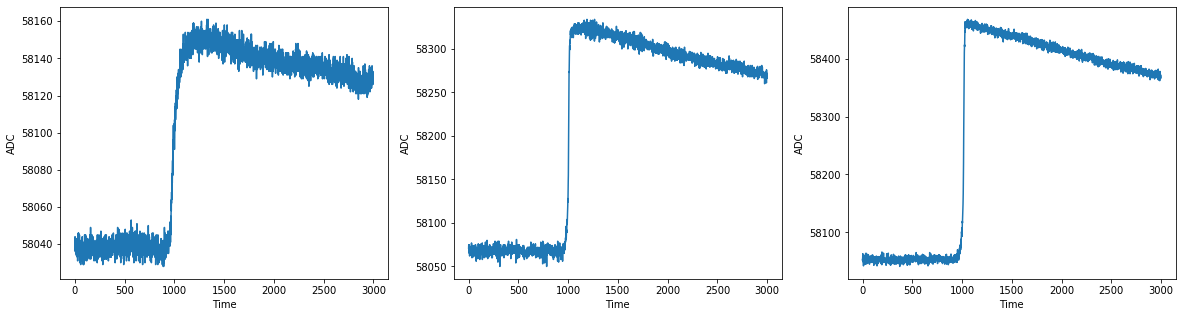

In [52]:
x1 = np.arange(0, len(waveform1))
x2 = np.arange(0, len(waveform2))
x3 = np.arange(0, len(waveform3))

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].plot(x1, waveform1)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('ADC')
ax[1].plot(x2, waveform2)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('ADC')
ax[2].plot(x3, waveform3)
ax[2].set_xlabel('Time')
ax[2].set_ylabel('ADC')
plt.show()

> I have chosen three random events to plot the waveforms for. You can see that some waveforms have a more sharpe transition into the charge bleed off and some are more gradual. You can also see that some waveforms are more noisy than others. We use many different types of waveform filters to smooth out the signal but the main one is called a trapazoid filter, however in the raw data this is not shown. I unfortunately couldn't find a multi-site event, my computer just can't process that much data so I would have to spend some time integrating the waveforms until I found one that could be a multi-site event waveform.